# 1. SGD
![avatar](https://mofanpy.com/static/results/ML-intro/speedup2.png)
把这些数据拆分成小批小批的, 然后再分批不断放入 NN 中计算, 这就是我们常说的 SGD 的正确打开方式了. 每次使用批数据, 虽然不能反映整体数据的情况, 不过却很大程度上加速了 NN 的训练过程, 而且也不会丢失太多准确率.

# 2. Momentum
![avatar](https://mofanpy.com/static/results/ML-intro/speedup4.png)
大多数其他途径是在更新神经网络参数那一步上动动手脚. 传统的参数 W 的更新是把原始的 W 累加上一个负的学习率(learning rate) 乘以校正值 (dx). 这种方法可能会让学习过程曲折无比, 看起来像 喝醉的人回家时, 摇摇晃晃走了很多弯路.
![avatar](https://mofanpy.com/static/results/ML-intro/speedup5.png)
所以我们把这个人从平地上放到了一个斜坡上, 只要他往下坡的方向走一点点, 由于向下的惯性, 他不自觉地就一直往下走, 走的弯路也变少了. 这就是 Momentum 参数更新.
其中b1*m就是惯性

#  3. AdaGrad
![avatar](https://mofanpy.com/static/results/ML-intro/speedup6.png)
这种方法是在学习率上面动手脚, 使得每一个参数更新都会有自己与众不同的学习率, 他的作用和 momentum 类似, 不过不是给喝醉酒的人安排另一个下坡, 而是给他一双不好走路的鞋子, 使得他一摇晃着走路就脚疼, 鞋子成为了走弯路的阻力, 逼着他往前直着走. 他的数学形式是这样的. 

# 4. RMSProp
![avatar](https://mofanpy.com/static/results/ML-intro/speedup7.png)
有了 momentum 的惯性原则 , 加上 adagrad 的对错误方向的阻力, 我们就能合并成这样. 让 RMSProp同时具备他们两种方法的优势. 

# 5. Adam
![avatar](https://mofanpy.com/static/results/ML-intro/speedup8.png)
计算m 时有 momentum 下坡的属性, 计算 v 时有 adagrad 阻力的属性, 然后再更新参数时 把 m 和 V 都考虑进去. 实验证明, 大多数时候, 使用 adam 都能又快又好的达到目标, 迅速收敛. 所以说, 在加速神经网络训练的时候, 一个下坡, 一双破鞋子, 功不可没.

# 6. 结果对比
![avatar](https://mofanpy.com/static/results/ML-intro/speedup3.png)

In [1]:
import torch
import torch.nn.functional as F
import torch.utils.data as Data
from torch.autograd import Variable
import matplotlib.pyplot as plt

# hyper parameter
LR = 0.01
BATCH_SIZE = 32
EPOCH = 30

# data
x = torch.unsqueeze(torch.linspace(-1,1,100),dim=1)
y = x.pow(2) + 0.1*torch.normal(torch.zeros(x.size()))

#plot dataset
plt.scatter(x.data.numpy(), y.data.numpy())
plt.show()

<Figure size 640x480 with 1 Axes>

In [2]:
# build batch dataset

torch_dataset = Data.TensorDataset(x,y)
loader = Data.DataLoader(
    dataset = torch_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 2
)

# build default network

class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)
        self.output = torch.nn.Linear(n_hidden, n_output)
    
    def forward(self, x):
        x = F.relu(self.hidden(x))
        x = self.output(x)
        
        return x

In [3]:
# define loss functio and optimizer
net_SGD         = Net(1,10,1)
net_Momentum    = Net(1,10,1)
net_RMSprop     = Net(1,10,1)
net_Adam        = Net(1,10,1)
nets = [net_SGD, net_Momentum, net_RMSprop, net_Adam]

opt_SGD         = torch.optim.SGD(net_SGD.parameters(), lr=LR)
opt_Momentum    = torch.optim.SGD(net_Momentum.parameters(), lr=LR, momentum=0.8)
opt_RMSprop     = torch.optim.RMSprop(net_RMSprop.parameters(), lr=LR, alpha=0.9)
opt_Adam        = torch.optim.Adam(net_Adam.parameters(), lr=LR, betas=(0.9, 0.99))
optimizers = [opt_SGD, opt_Momentum, opt_RMSprop, opt_Adam]

loss_func = torch.nn.MSELoss()
losses_his = [[], [], [], []]   # record loss

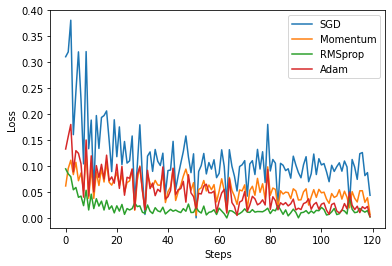

In [4]:
for epoch in range(EPOCH):
    for step, (batch_x, batch_y) in enumerate(loader):
        for net, opt, l_his in zip(nets, optimizers, losses_his):
            output = net(batch_x)
            loss = loss_func(output,batch_y)
            opt.zero_grad()
            loss.backward()
            opt.step()
            l_his.append(loss.data.numpy())
            
labels = ['SGD', 'Momentum', 'RMSprop', 'Adam']
for i, l_his in enumerate(losses_his):
    plt.plot(l_his, label=labels[i])
plt.legend(loc='best')
plt.xlabel('Steps')
plt.ylabel('Loss')
# plt.ylim((0, 0.2))
plt.show()